<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Apr 27 22:11:25 UTC 2021


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 93 (delta 21), reused 77 (delta 10), pack-reused 0
Unpacking objects: 100% (93/93), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 86kB/s 
     |████████████████████████████████| 133kB 43.1MB/s 
     |████████████████████████████████| 13.2MB 342kB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 10.3MB 28.3MB/s 
     |████████████████████████████████| 112kB 47.6MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 1.2MB 41.2MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 


In [4]:
# extract everything
!ls /content/BMGP_2020/data/10xFB_5k_pbmc_v3/*/*.tar.gz |xargs -n1 tar -xf

# Imports

In [47]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

def nd(arr):
  return np.asarray(arr).reshape(-1)

colors = {
    "kb": "black",
    "cr": "red"
}

In [6]:
raw_kb = anndata.read_h5ad("/content/counts_unfiltered/adata.h5ad")

In [7]:
# cellranger outputs genes by cells, we output cells by genes
mtx_path = "/content/raw_feature_bc_matrix/matrix.mtx.gz"
mtx = mmread(mtx_path)
mmwrite("matrix_T.mtx", mtx.T)
!yes | gzip matrix_T.mtx

In [8]:
!gunzip /content/raw_feature_bc_matrix/features.tsv.gz
!cut -d$'\t' -f 1 /content/raw_feature_bc_matrix/features.tsv > features_1_col.tsv
!gzip features_1_col.tsv

In [9]:
raw_cr = import_matrix_as_anndata("./matrix_T.mtx.gz", "/content/raw_feature_bc_matrix/barcodes.tsv.gz", "features_1_col.tsv.gz", t2g_path="/content/BMGP_2020/references/10xFB_5k_pbmc_v3/kite/f2b.txt")
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [10]:
df = pd.read_csv("/content/filtered_feature_bc_matrix/barcodes.tsv.gz", names=["bcs"], header=None)
df["bcs"] = df["bcs"].str.slice(0, 16).values

In [11]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [12]:
kb = raw_kb[raw_kb.obs.index.isin(common)]
cr = raw_cr[raw_cr.obs.index.isin(common)]

In [15]:
print(kb)
print(cr)

View of AnnData object with n_obs × n_vars = 5266 × 32
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 5266 × 32
    var: 'gene_name'


# Visualizations

## Knee

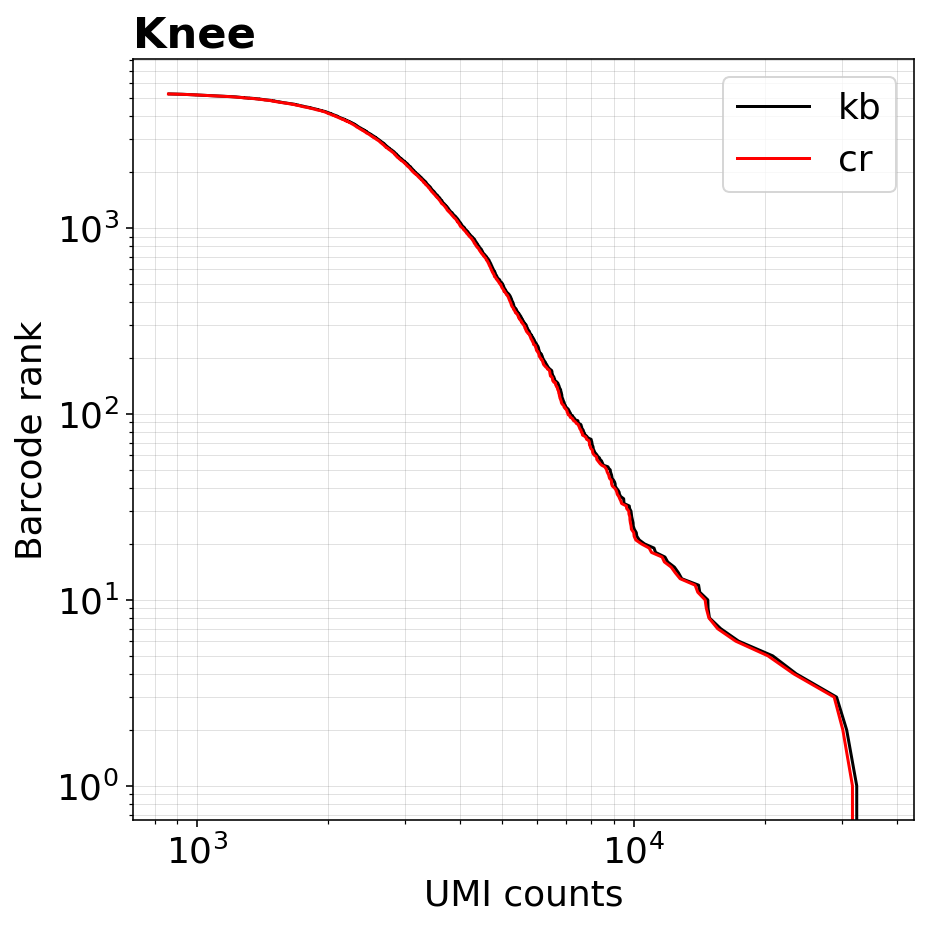

In [38]:
fig, ax = plt.subplots(figsize=(7,7))

x = np.sort(nd(kb.X.sum(axis=1)))[::-1]
y = np.arange(kb.shape[0])

ax.plot(x,y, label="kb", color=colors["kb"])

x = np.sort(nd(cr.X.sum(axis=1)))[::-1]
y = np.arange(cr.shape[0])

ax.plot(x,y, label="cr", color=colors["cr"])

ax.set(**{
    "xlabel": "UMI counts",
    "ylabel": "Barcode rank",
    "xscale": "log",
    "yscale": "log"
})
ax.legend()
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title('Knee', fontweight='bold', loc = 'left' )
fig.show()

In [37]:
def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

## pseudobulk

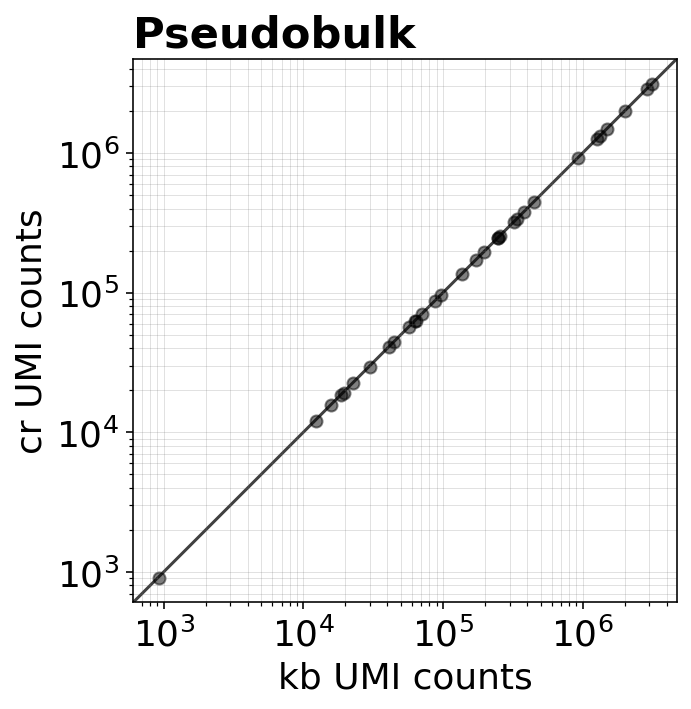

In [40]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(kb.X.sum(axis=0))
y = nd(cr.X.sum(axis=0))
ax.scatter(x,y, alpha = 0.5, color="k")

ax.set(**{
    'xscale': 'log',
    'yscale': 'log',
    'xlabel': 'kb UMI counts',
    'ylabel': 'cr UMI counts'
})
yex(ax)

ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title('Pseudobulk', fontweight='bold', loc = 'left' )
fig.show()

In [41]:
# Correlations
def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

In [42]:
corr = sparse_M_corr(kb.X.T, cr.X.T)

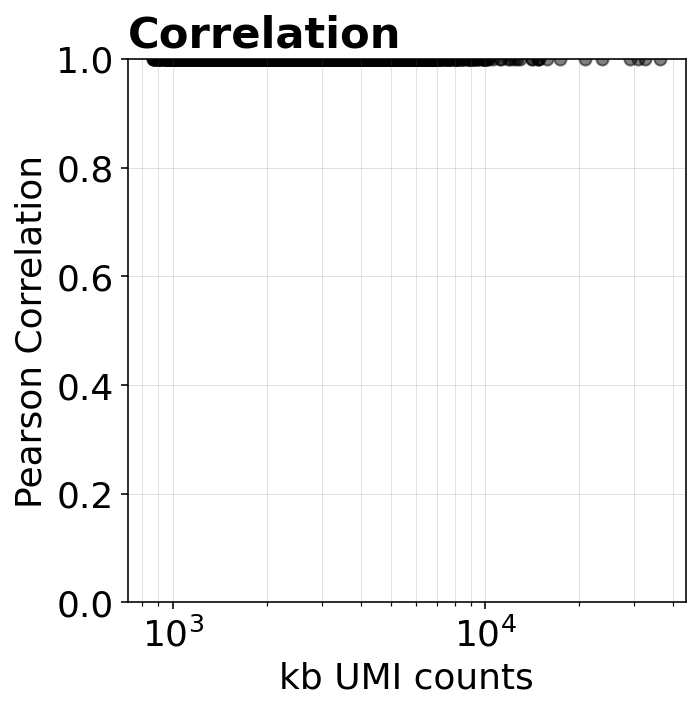

In [43]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(kb.X.sum(axis=1))
y = corr
ax.scatter(x,y, alpha=0.5, color="k")

ax.set(**{
    'xscale': 'log',
    'ylim': (0,1),
    'xlabel': 'kb UMI counts',
    'ylabel': 'Pearson Correlation'
})

ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)

ax.set_title('Correlation', fontweight='bold', loc = 'left' )

fig.show()

### $l_1$ dist

In [51]:
from sklearn.metrics.pairwise import manhattan_distances

def l1_dist(X, Y):
    '''
    computes manhattan distance between corresponding cells, and nearest cells
        X: A.layers['log1p']
        Y: B.layers['log1p']
    '''
    dist_AA = manhattan_distances(X, X)
    dist_AB = manhattan_distances(X, Y)

    # nkc are the kallisto-alevin distances
    dist_AB = np.diagonal(dist_AB)

    # ncc are the kallisto-kallisto distances
    AA = []
    for row in dist_AA:
        val = np.partition(row, 1)[1]
        AA.append(val)
    dist_AA = AA

    return dist_AA, dist_AB

dist_AA, dist_AB = l1_dist(np.log1p(kb.X), np.log1p(cr.X))
dist_BB, dist_BA = l1_dist(np.log1p(cr.X), np.log1p(kb.X))

In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_hist(A, B, orientation="vertical", ax=None):
    hist, concat_bins = np.histogram(np.concatenate((A,B)), bins='auto')
    hist, A_bins =  np.histogram(A, bins='auto')
    hist, B_bins =  np.histogram(B, bins='auto')

    best_bins = min([A_bins,concat_bins,B_bins], key=len) # may need to change to max
    best_bins = concat_bins
    ax.hist(A, bins=concat_bins, orientation=orientation, color=colors["kb"], label="kb", alpha=1,)# bins=best_bins)
    ax.hist(B, bins=concat_bins, orientation=orientation, color=colors["cr"], label="cr", alpha=1,)# bins=best_bins)
    return ax

def make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=None):
    x = dist_AA
    y = dist_AB

    xx = dist_BA
    yy = dist_BB

    # the scatter plot:
    ax.scatter(x, y, label="kb", color=colors["kb"])
    ax.scatter(xx, yy, label="cr", color=colors["cr"])
#    ax.set(**{'yscale': 'log', 'xscale':'log'})
    ax.set_aspect(1.)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 1.5, pad=0.075, sharex=ax)
    axHisty = divider.append_axes("right", 1.5, pad=0.075, sharey=ax)

    # make some labels invisible
    axHistx.xaxis.set_tick_params(labelbottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False)


    ## Right histogram,  cellranger-cellranger, kallisto-cellranger,
    axHisty = make_hist(y, yy, orientation="horizontal", ax=axHisty)

    # kallisto-kallisto, cellranger-kallisto
    axHistx = make_hist(x, xx, orientation="vertical", ax=axHistx)


    # the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
    # thus there is no need to manually adjust the xlim and ylim of these
    # axis.
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.set_xlabel("$\ell_1$ to nearest kb", fontsize=fsize)
    ax.set_ylabel("$\ell_1$ to nearest cr", fontsize=fsize)
    axHistx.set_ylabel("Barcode counts", fontsize=fsize-8)
    axHisty.set_xlabel("Barcode counts", fontsize=fsize-8)

    axHistx.legend(fontsize=fsize-5, loc="upper right")
    return axHistx

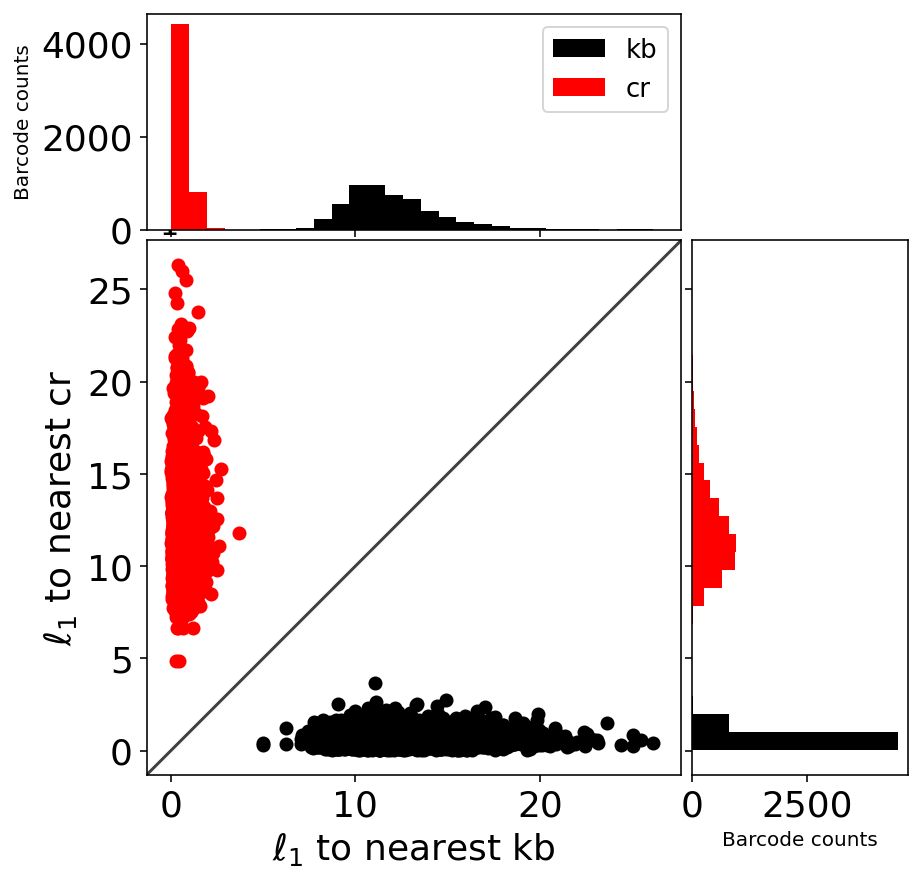

In [54]:
fig, ax = plt.subplots(figsize=(7,7))

make_scatter_hist(dist_AA, dist_BB, dist_AB, dist_BA, ax=ax)
ax.set_title('$\ell_1$ distance', fontweight='bold', loc = 'left' ) # needs to be shifted up

fig.show()

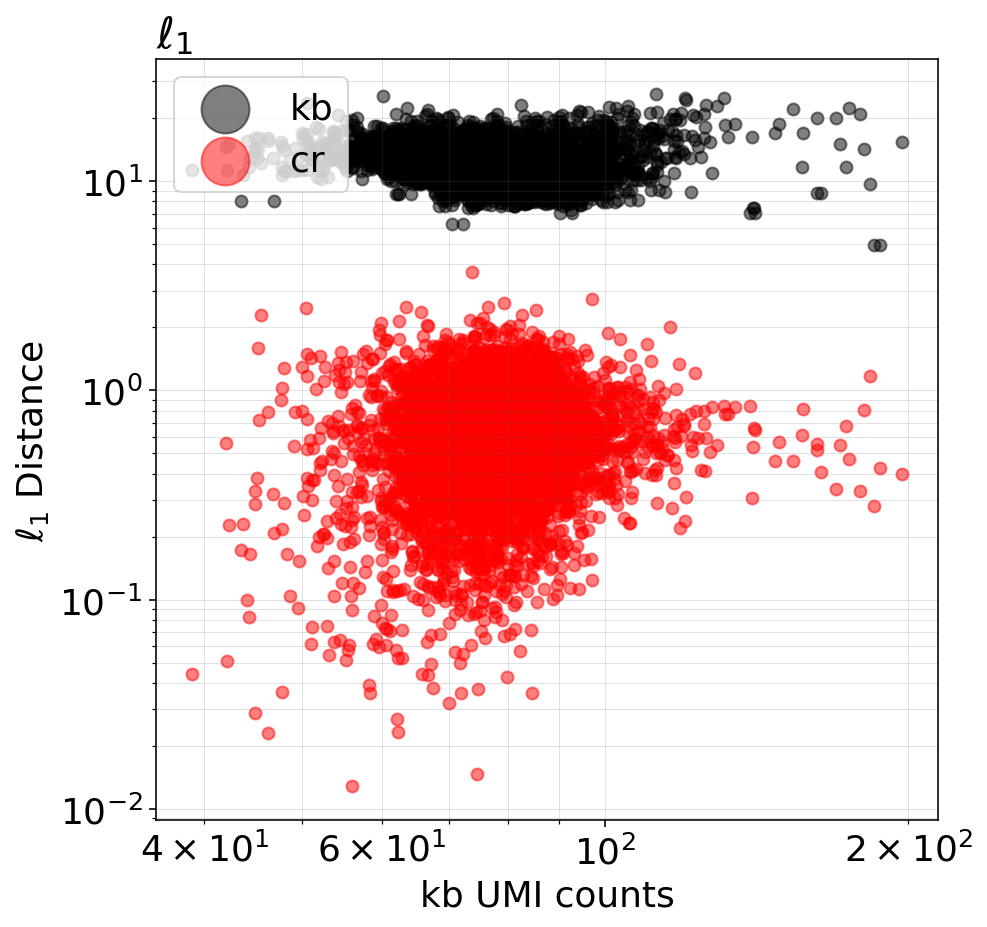

In [61]:
fig, ax = plt.subplots(figsize=(7,7))

title = "$\ell_1$"

cnts = nd(np.log1p(kb.X).sum(1))

ax.scatter(cnts, dist_AA, color=colors["kb"], alpha=0.5, label="kb")
ax.scatter(cnts, dist_AB, color=colors["cr"], alpha=0.5, label="cr")

ax.set(**{
    "xlabel": "kb UMI counts",
    "ylabel": "$\ell_1$ Distance",
    'xscale': 'log',
    'yscale': 'log',
})

ax.legend(markerscale=4, loc='upper left')
ax.grid(which='both', linestyle='-', linewidth='0.5', color='dimgrey', alpha=0.2)


ax.set_title(title, fontweight='bold', loc = 'left' )
fig.show()

----------------------------------------

# Ignore everything below this

In [ ]:
fsize = 20
gridalpha = 0.2

def knee_plot(mtx, ax=None, **kwargs):
    '''
        Makes knee plot.
        A: adata
        kwargs: [c = _lighten_color(B_color, 0.5), linewidth=2, alpha=1]
    '''
    ax = ax or plt.gca()

    ranked_umi = np.sort(mtx, axis=None)[::-1] # reversed
    ax.plot(ranked_umi, np.arange(len(ranked_umi)), **kwargs)
    return ax

def knee_plot_settings(mtx, ax=None):
    ax = ax or plt.gca()
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('UMI counts',fontsize=fsize)
    ax.set_ylabel('Cumulative number of barcodes',fontsize=fsize)
    ax.set_title('',loc='center')
    #ax.set_title('A', fontweight='bold', fontsize = fsize, loc = 'left' )
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    return ax

def plot_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None, ax_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(ax_label))
    ax.set_ylabel("{}2".format(ax_label))
    if plot_label is None:
        plot_label = ""
        
    if ax_label is None:
        ax_label = ""

    if labels is not None:
        scatter = ax.scatter(x,y, c=labels, cmap="PuOr", label=plot_label)
        ax.legend(markerscale = 0)
        return scatter
    scatter = ax.scatter(x,y, color="black")
    return scatter

def plot_discrete_embedding(Y, comp=[0,1], labels=None, ax=None, plot_label=None, ax_label=None):
    x = Y[:,comp[0]]
    y = Y[:,comp[1]]

    ax = ax or plt.gca()

    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("{}1".format(ax_label))
    ax.set_ylabel("{}2".format(ax_label))
    if plot_label is None:
        plot_label = ""
        
    if ax_label is None:
        ax_label = ""

    if labels is not None:
        scatter = ax.scatter(x,y, c=labels, cmap="tab20b", label=plot_label)
        ax.legend(markerscale = 0)
        return scatter
    scatter = ax.scatter(x,y, color="black")
    return scatter

def plot_bulk(X, Y, xlabel=None, ylabel=None, ax=None, color="black"):
    ax = ax or plt.gca()
    
    ax.set_xlim((10, 10**6))
    ax.set_ylim((10, 10**6))
    ax.set_xlabel(xlabel, fontsize=fsize)
    ax.set_ylabel(ylabel, fontsize=fsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yscale("log", nonposy='clip')
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    
    
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    
    ax.scatter(X, Y, c=color, s=10, alpha=0.2)

    return ax

def _sparse_M_std(X):
    n = X.shape[0]
    return np.sqrt(n * X.multiply(X).sum(0) - np.multiply(X.sum(0), X.sum(0)))

def sparse_M_corr(X, Y):
    '''
        Computes Pearson correlation between X and Y (both in sparse format). Must be same shape.
        X: A_raw[common_obs.index].layers['log1p'] # raw
        Y: B_raw[common_obs.index].layers['log1p']# raw
        X: A.layers['log1p'] # filtered
        Y: B.layers['log1p'] # filtered
        Notes: I changed the axis in sum and shape, need to check if right
    '''
    X_std = _sparse_M_std(X)
    Y_std = _sparse_M_std(Y)
    XY_std = np.multiply(X_std, Y_std)
    n = X.shape[0]
    XY_cov = n*X.multiply(Y).sum(0) - np.multiply(X.sum(0), Y.sum(0))
    R = np.divide(XY_cov, XY_std)
    return np.squeeze(np.asarray(R))

def corr_plot(X, Y, xlabel=None, ax=None, leg=None):
    ax = ax or plt.gca()

    ax.set_xscale('log')
    ax.set_xlim(1,10**6)
    ax.set_ylim(0,1)
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)
    ax.set_xlabel(xlabel, fontsize = fsize)
    ax.set_ylabel('Pearson Correlation', fontsize = fsize)
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1])

    ax.scatter(X, Y, c="black", s=10, alpha=0.2, label=leg[0]+" vs. "+leg[1])
    ax.legend()
    return ax

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar=0
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

### Perform kmeans, PCA, TSNE, UMAP on kite

In [ ]:
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [ ]:
%%time
YY_pca = pca.fit_transform(kite.layers["log1p"])
YY_tsne = tsne.fit_transform(kite.layers["log1p"])
YY_umap = umap.fit_transform(kite.layers["log1p"])

CPU times: user 1min 21s, sys: 7.83 s, total: 1min 29s
Wall time: 46 s


In [ ]:
kite.obs["PCA0"] = YY_pca[:,0]
kite.obs["PCA1"] = YY_pca[:,1]
kite.obs["TSNE0"] = YY_tsne[:,0]
kite.obs["TSNE1"] = YY_tsne[:,1]
kite.obs["UMAP0"] = YY_umap[:,0]
kite.obs["UMAP1"] = YY_umap[:,1]

Trying to set attribute `.obs` of view, making a copy.


## Perform kmeans, PCA, TSNE, UMAP on cite-seq

In [ ]:
pca = pca = PCA(n_components=2, random_state=random_state)
tsne = TSNE(random_state=random_state)
umap = UMAP(random_state=random_state)

In [ ]:
%%time

YY_pca = pca.fit_transform(cr.layers["log1p"])
YY_tsne = tsne.fit_transform(cr.layers["log1p"])
YY_umap = umap.fit_transform(cr.layers["log1p"])

AttributeError: 'ArrayView' object has no attribute 'todense'

In [ ]:
cr.obs["PCA0"] = YY_pca[:,0]
cr.obs["PCA1"] = YY_pca[:,1]
cr.obs["TSNE0"] = YY_tsne[:,0]
cr.obs["TSNE1"] = YY_tsne[:,1]
cr.obs["UMAP0"] = YY_umap[:,0]
cr.obs["UMAP1"] = YY_umap[:,1]

Trying to set attribute `.obs` of view, making a copy.


In [ ]:
cr.write_h5ad("./save/cr_adata.h5ad")

# Data Visualizations

## PCA on normalized counts

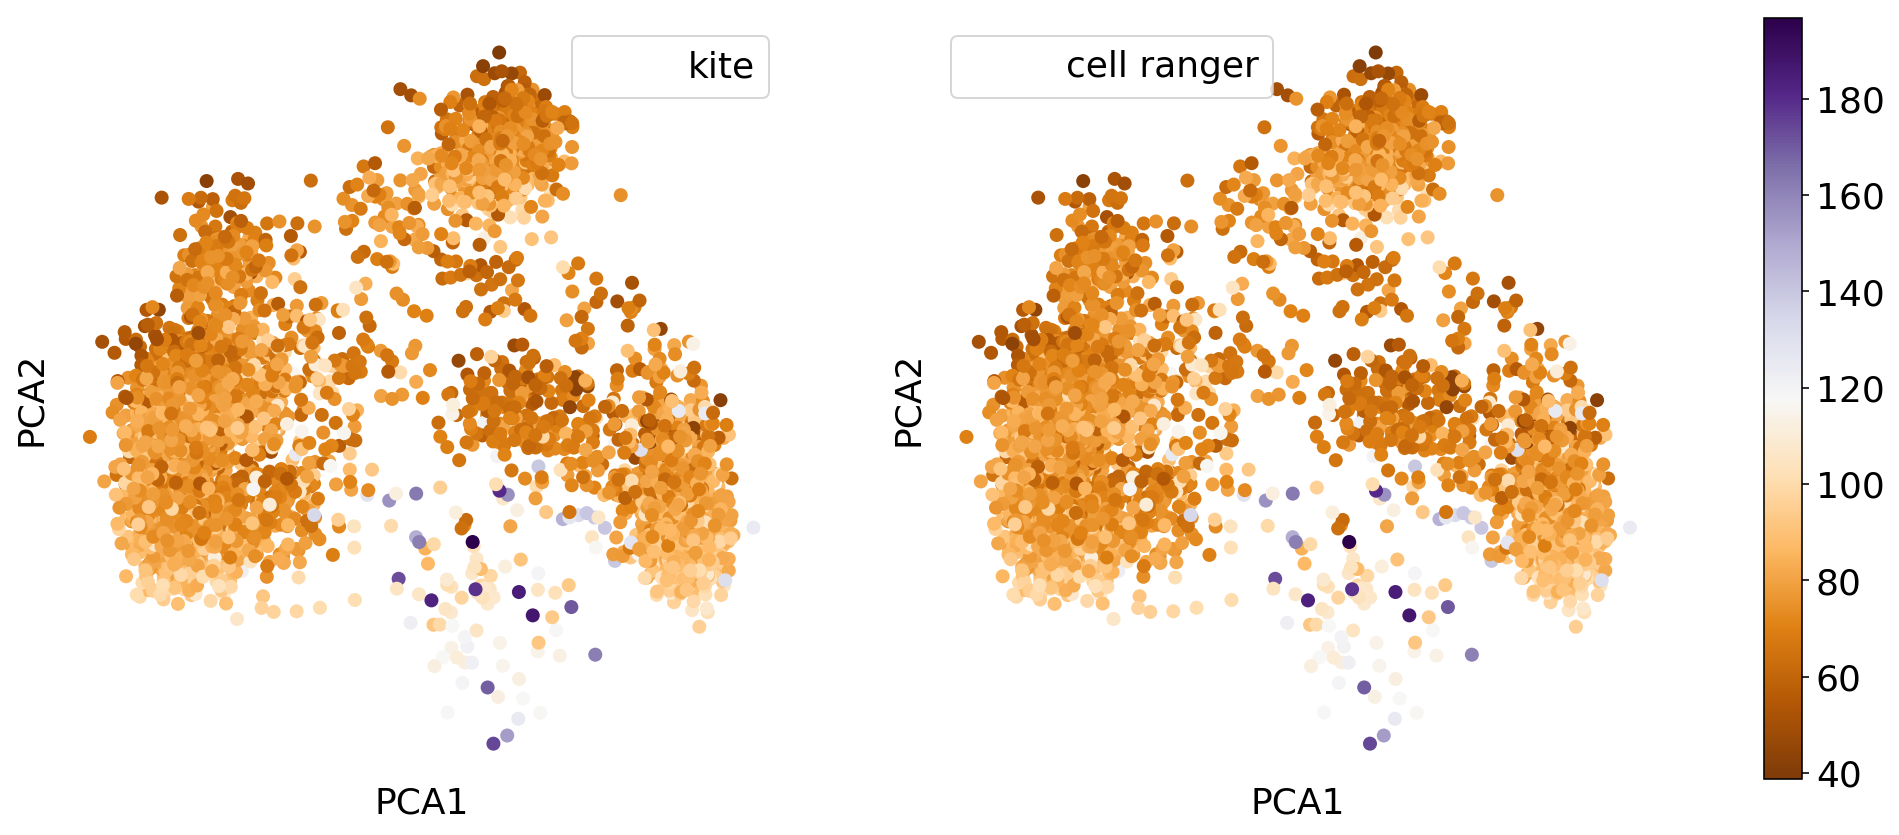

In [ ]:
fig, ax = plt.subplots(figsize=(9*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"PCA0":"PCA1"].values, labels=kite.obs.log1p_counts, ax=ax[0], ax_label="PCA", plot_label="kite")
im = plot_embedding(cr.obs.loc[:,"PCA0":"PCA1"].values, labels=cr.obs.log1p_counts, ax=ax[1], ax_label="PCA", plot_label="cell ranger")

fig.colorbar(im, ax=ax.ravel().tolist())

plt.show()

## UMAP on normalized counts

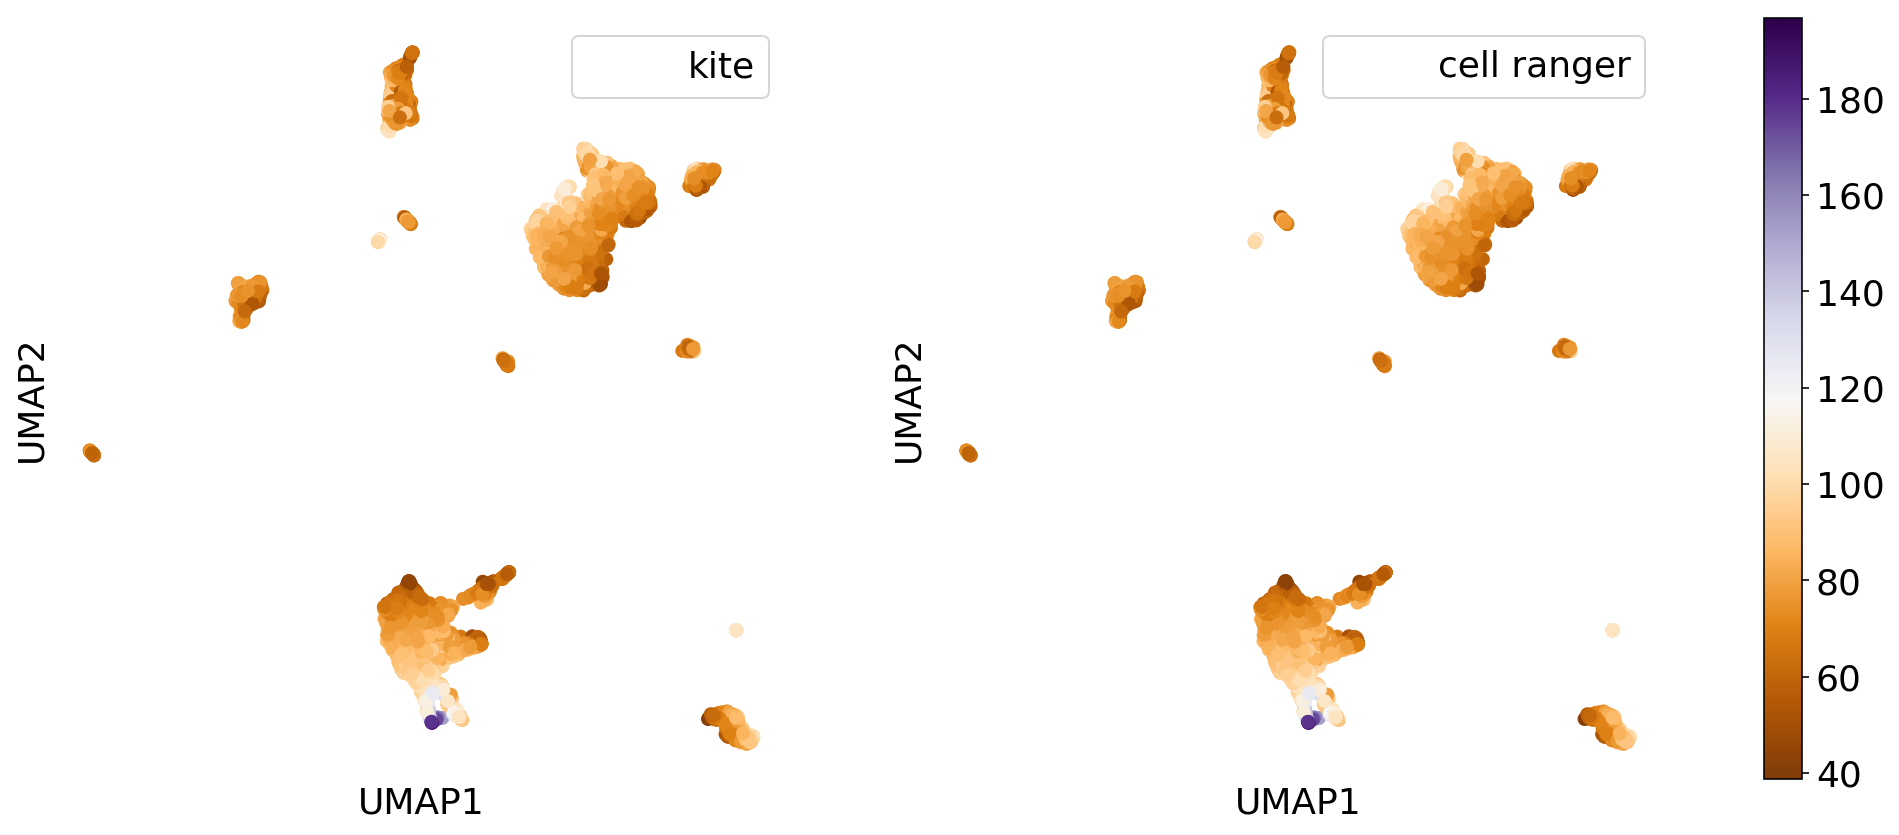

In [ ]:
fig, ax = plt.subplots(figsize=(9*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"UMAP0":"UMAP1"].values, labels=kite.obs.log1p_counts, ax=ax[0], ax_label="UMAP", plot_label="kite")
im = plot_embedding(cr.obs.loc[:,"UMAP0":"UMAP1"].values, labels=cr.obs.log1p_counts, ax=ax[1], ax_label="UMAP", plot_label="cell ranger")

fig.colorbar(im, ax=ax.ravel().tolist())

plt.show()

## tSNE on normalized counts

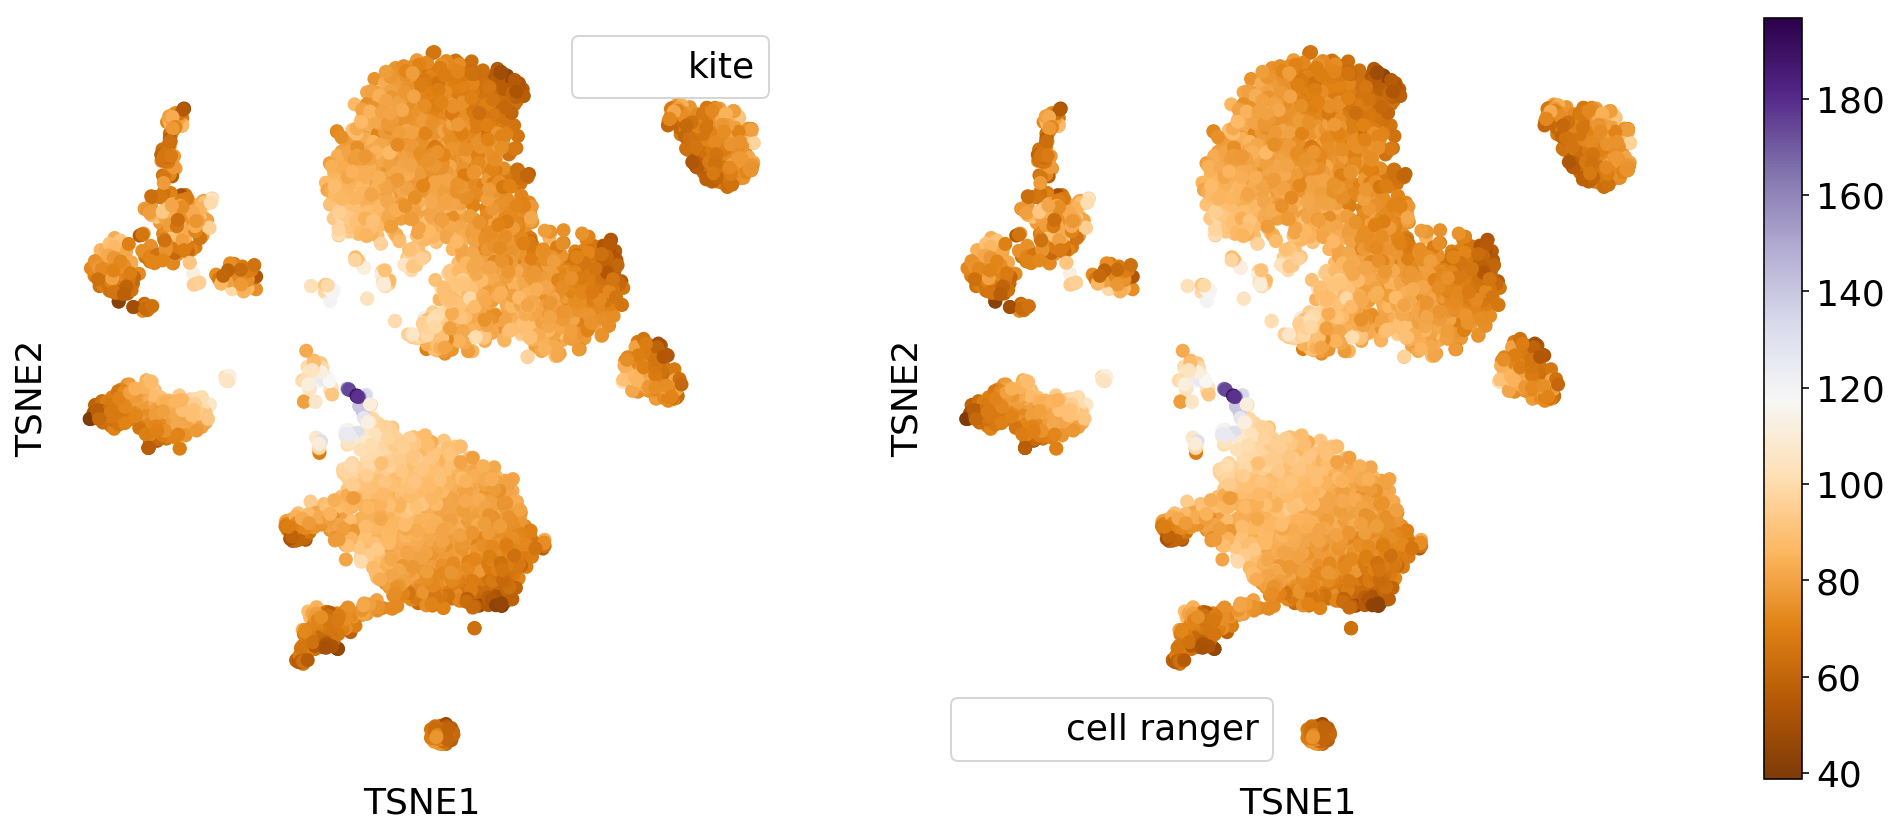

In [ ]:
fig, ax = plt.subplots(figsize=(9*2, 7), ncols=2)

plot_embedding(kite.obs.loc[:,"TSNE0":"TSNE1"].values, labels=kite.obs.log1p_counts, ax=ax[0], ax_label="TSNE", plot_label="kite")
im = plot_embedding(cr.obs.loc[:,"TSNE0":"TSNE1"].values, labels=cr.obs.log1p_counts, ax=ax[1], ax_label="TSNE", plot_label="cell ranger")

fig.colorbar(im, ax=ax.ravel().tolist())

plt.show()